In [1]:
import os
import pickle
import prince
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.font_manager import FontProperties

# 獲取當前工作目錄
current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
version3_path = os.path.join(parent_dir, "Version3")

# 暫時將工作目錄切換到 Version3
os.chdir(version3_path)

from sklearn.cluster import AgglomerativeClustering
from tdamapper.core_old import MapperAlgorithm
from tdamapper.cover import CubicalCover
from tdamapper.clustering import FailSafeClustering

from utils.utils_v3 import *
from utils.plots import *
from utils.preprocess import preprocess, process_other, get_unique_ids

try:
    myfont = FontProperties(fname=r"/System/Library/Fonts/PingFang.ttc")
    sns.set(style="whitegrid", font=myfont.get_name())
except Exception as e:
    print(e)

plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']
plt.rcParams['axes.unicode_minus'] = False

dataA2 = pd.read_csv("./Data/A2.csv", low_memory=False)
dataA1 = pd.read_csv("./Data/A1.csv")

[Errno 2] No such file or directory: 'C:\\System\\Library\\Fonts\\PingFang.ttc'


In [2]:
select_lst = [
    # 月份是為了篩選每個月2萬筆
    '發生月份',

    '天候名稱', '光線名稱', 
    '道路類別-第1當事者-名稱', '速限-第1當事者', 
    '路面狀況-路面鋪裝名稱', '路面狀況-路面狀態名稱', '路面狀況-路面缺陷名稱',
    '道路障礙-障礙物名稱', '道路障礙-視距品質名稱', '道路障礙-視距名稱',
    '號誌-號誌種類名稱', '號誌-號誌動作名稱',
    '車道劃分設施-分道設施-快車道或一般車道間名稱', '車道劃分設施-分道設施-快慢車道間名稱', '車道劃分設施-分道設施-路面邊線名稱',
    '當事者屬-性-別名稱', '當事者事故發生時年齡',
    '保護裝備名稱', '行動電話或電腦或其他相類功能裝置名稱',
    '肇事逃逸類別名稱-是否肇逃',
    '死亡受傷人數',

    # 大類別
    '道路型態大類別名稱', '事故位置大類別名稱',
    '車道劃分設施-分向設施大類別名稱',
    '事故類型及型態大類別名稱', '當事者區分-類別-大類別名稱-車種', '當事者行動狀態大類別名稱',
    '車輛撞擊部位大類別名稱-最初', '車輛撞擊部位大類別名稱-其他',

    # 兩個欄位只有兩個觀察值不同
    '肇因研判大類別名稱-主要',
    # '肇因研判大類別名稱-個別',
    
    # 子類別
    '道路型態子類別名稱', '事故位置子類別名稱', '事故類型及型態子類別名稱', '肇因研判子類別名稱-主要',
    '當事者區分-類別-子類別名稱-車種', '當事者行動狀態子類別名稱', '車輛撞擊部位子類別名稱-最初',
    '車輛撞擊部位子類別名稱-其他', '肇因研判子類別名稱-個別',
]

In [3]:
full_dataA1 = preprocess(dataA1, target='汽車', lst=select_lst)
full_dataA2 = preprocess(dataA2, target='汽車', lst=select_lst)
mapper_numpy, rbind_data, dummy_data, death = process_other(full_dataA1, full_dataA2, downsample=False)

[]
dummy_data: (111956, 453)


# MCA

In [ ]:
mca = prince.MCA(
    one_hot=False,
    n_components=9,
    n_iter=30,
    copy=True,
    check_input=True,
    random_state=42
)

mca.fit(dummy_data)
lens = mca.transform(dummy_data)

print(mca.eigenvalues_summary)

eigenvalues = mca.eigenvalues_

components = range(0, len(eigenvalues))

variance = mca.eigenvalues_summary['% of variance']

plt.figure(figsize=(10, 6))
plt.plot(components, eigenvalues, marker='o', linestyle='--')
plt.title("Scree Plot")
plt.xlabel("Component")
plt.ylabel("Eigenvalue")
plt.xticks(components)
plt.grid(True)
plt.show()

In [ ]:
plot_mca(mca, dummy_data)

In [5]:
# grid_search_info = {
#     'lens': lens,
#     'mapper_numpy': mapper_numpy,
#     'rbind_data': rbind_data,
# }
# with open('../ForMatrix/CalculatedData/car.pkl', 'wb') as f:
#     pickle.dump(grid_search_info, f)

In [ ]:
overlap = 2
interval = 10
detailed_results = []
silhouette_for_intervals = []

mapper_algo = MapperAlgorithm(
    cover=CubicalCover(
        n_intervals=interval,
        overlap_frac=overlap / 10
    ),
    clustering=FailSafeClustering(
        AgglomerativeClustering(
            n_clusters=2,
            linkage='ward'
        )
    ),
    n_jobs=10
)

mapper_info = mapper_algo.fit_transform(mapper_numpy, lens)
silhouette_for_intervals.append(mapper_info[1])
result = {
    "overlap": overlap,
    "interval": interval,
    "silhouette": mapper_info[1],
    "mapper_info": mapper_info
}
detailed_results.append(result)
detailed_results_df = pd.DataFrame(detailed_results)

In [4]:
output_file = './Data/Mapper/car_o2i10.pkl'

with open(output_file, 'rb') as f:
    detailed_results_df = pickle.load(f)

# with open(output_file, 'wb') as f:
#     pickle.dump(detailed_results_df, f)

# 目前分析使用的模型

In [ ]:
choose = '天候名稱'

for i in [5]:
    print(f'Seed: {i}')
    mapper_plotter = MapperPlotter(detailed_results_df['mapper_info'][0], rbind_data, seed=i, iterations=50,
                                   range_lst=[-0.05, 0.05, 0.1, -0.1], dim=3)
    mapper_plot = mapper_plotter.create_mapper_plot(choose, most_common_encoded_label, avg=False)
    full_info, outlier_info = mapper_plotter.extract_data(rz=45, ry=-20)
    mapper_plotter.map_colors(choose, size=15, threshold=5)
    mapper_plotter.plot(choose, avg=False, set_label=True, size=3000)

In [ ]:
choose = '顯著特徵'
rbind_data['顯著特徵'] = rbind_data['道路型態子類別名稱'] + ',' + rbind_data['號誌-號誌動作名稱'] + ',' + rbind_data['天候名稱']

mapper_plotter = MapperPlotter(detailed_results_df['mapper_info'][0], rbind_data, seed=i, iterations=50,
                                range_lst=[-0.05, 0.05, 0.1, -0.1], dim=3)
mapper_plot = mapper_plotter.create_mapper_plot(choose, most_common_encoded_label, avg=False)
full_info, outlier_info = mapper_plotter.extract_data(rz=45, ry=-20)
mapper_plotter.map_colors(choose, size=15, threshold=500)
mapper_plotter.plot(choose, avg=False, set_label=True, size=3000)

In [ ]:
choose = '死亡'
rbind_data['死亡'] = death

for i in [5]:
    print(f'Seed: {i}')
    mapper_plotter = MapperPlotter(detailed_results_df['mapper_info'][0], rbind_data, seed=i, iterations=50,
                                   range_lst=[-0.15, 0.175, 0.2, -0.2], dim=3)
    mapper_plot = mapper_plotter.create_mapper_plot(choose, sum_of_data, avg=True)
    full_info, label_out = mapper_plotter.extract_data(rz=45, ry=-20)
    mapper_plotter.map_colors(choose, size=15, threshold=0)
    mapper_plotter.plot_dens(choose, avg=True, set_label=False, size=3000, minimum_lst=[-0.04, 0.01]) 

# Polygon

01/26/2025 11:29:52 PM legend WARNING: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


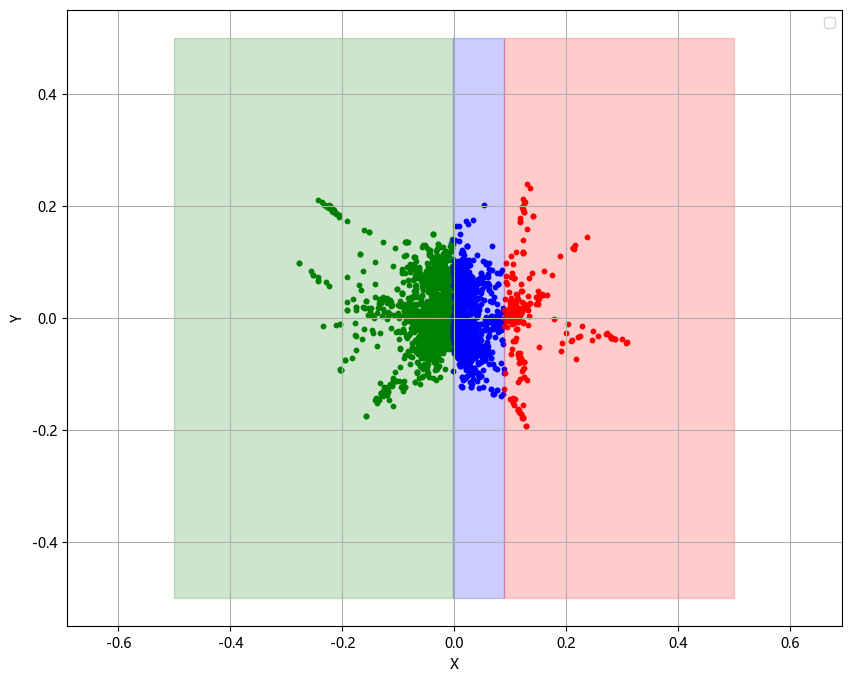

In [118]:
from shapely.geometry import Point, Polygon

threshold1 = -0.0017
threshold2 = 0.0889
x_max = 0.5
x_min = -0.5
y_max = 0.5
y_min = -0.5

rectangle1 = Polygon([(threshold1, y_min), (x_min, y_min), (x_min, y_max), (threshold1, y_max)])
rectangle2 = Polygon([(threshold1, y_min), (threshold1, y_max), (threshold2, y_max), (threshold2, y_min)])
rectangle3 = Polygon([(threshold2, y_min), (threshold2, y_max), (x_max, y_max), (x_max, y_min)])

th = 2
filtered_full_info = full_info[(full_info['y'] > -th) &
                               (full_info['y'] < th) &
                               (full_info['x'] > -th) &
                               (full_info['x'] < th)]
# filtered_full_info = full_info

# 檢查每個點是否在任意一個區塊內
inside_indices_1 = filtered_full_info.apply(lambda row: Point(row['x'], row['y']).within(rectangle1), axis=1)
inside_indices_2 = filtered_full_info.apply(lambda row: Point(row['x'], row['y']).within(rectangle2), axis=1)
inside_indices_3 = filtered_full_info.apply(lambda row: Point(row['x'], row['y']).within(rectangle3), axis=1)

label_0 = filtered_full_info[inside_indices_1]
label_1 = filtered_full_info[inside_indices_2]
label_2 = filtered_full_info[inside_indices_3]

# 繪製數據點和矩形區塊
plt.figure(figsize=(10, 8))
plt.scatter(label_0['x'], label_0['y'], color='green', s=10)
plt.scatter(label_1['x'], label_1['y'], color='blue', s=10)
plt.scatter(label_2['x'], label_2['y'], color='red', s=10)
# 繪製矩形區塊
for rect, color, alpha in zip([rectangle1, rectangle2, rectangle3], 
                              ['green', 'blue', 'red'], 
                              [0.2, 0.2, 0.2]):
    x, y = rect.exterior.xy
    plt.fill(x, y, color=color, alpha=alpha)
# 圖形調整
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.grid(True)
plt.axis("equal")
plt.show()

In [ ]:
plot_labels(label_0, label_1, label_out, title="Label and Outlier Visualization")

In [121]:
rbind_data['死亡'] = death
# 獲取每個label的index
count_0 = get_unique_ids(label_0)
count_1 = get_unique_ids(label_1)
count_2 = get_unique_ids(label_2)
count_out = get_unique_ids(label_out)

index_to_groups = {}

# 將索引與群體的關係記錄下來
for group_name, group_indexes in zip(
    ["full_0", "full_1", "full_2", "full_out"],
    [count_0, count_1, count_2, count_out],
):
    for idx in group_indexes:
        if idx not in index_to_groups:
            index_to_groups[idx] = set()
        index_to_groups[idx].add(group_name)

# 找交集索引
intersection_indexes = {idx for idx, groups in index_to_groups.items() if len(groups) > 1}

# 移除交集的index
count_0 = [i for i in count_0 if i not in intersection_indexes]
count_1 = [i for i in count_1 if i not in intersection_indexes]
count_2 = [i for i in count_2 if i not in intersection_indexes]
count_out = [i for i in count_out if i not in intersection_indexes]


full_0 = rbind_data.loc[count_0]
full_1 = rbind_data.loc[count_1]
full_2 = rbind_data.loc[count_2]
full_out = rbind_data.loc[count_out]
overlap_data = rbind_data.loc[list(intersection_indexes)]

# 確認所有資料都被獲取
assert len(count_0) == full_0.shape[0]
assert len(count_1) == full_1.shape[0]
assert len(count_2) == full_2.shape[0]
assert len(count_out) == full_out.shape[0]

print(full_0.shape[0] + full_1.shape[0] + full_2.shape[0] + full_out.shape[0] + overlap_data.shape[0])
print(rbind_data.shape[0])


111956
111956


In [122]:

print(full_0['死亡'].value_counts())
print(full_1['死亡'].value_counts())
print(full_2['死亡'].value_counts())
print(full_out['死亡'].value_counts())
print(overlap_data['死亡'].value_counts())

0    57472
1      278
2        6
3        1
Name: 死亡, dtype: int64
0    43045
1      171
2        3
3        1
Name: 死亡, dtype: int64
0    2084
1      28
2       6
3       1
Name: 死亡, dtype: int64
0    4441
1      63
2       2
3       1
Name: 死亡, dtype: int64
0    4331
1      22
Name: 死亡, dtype: int64


In [123]:
full_info.to_csv('./Data/CarData/full_info.csv', index=False)
full_0.to_csv('./Data/CarData/full_0.csv', index=False)
full_1.to_csv('./Data/CarData/full_1.csv', index=False)
full_2.to_csv('./Data/CarData/full_2.csv', index=False)
full_out.to_csv('./Data/CarData/full_out.csv', index=False)
overlap_data.to_csv('./Data/CarData/overlap_data.csv', index=False)